# **Overfitting comparison between the two models**

## **Preliminary steps**

In [92]:
### PACKAGES

import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization
from src.libs.tokenizer import CharacterLevelTokenizer, ReversedPairingTokenizer
from src.model.attention_modified import MyTransformer


In [124]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")


Using device: cpu


In [125]:
### SAVING PATH

SAVING_PATH = os.path.join("output", "overfitting")


## **Tokenizer**

In [126]:
### CREATE TOKENIZER

tokenizer = CharacterLevelTokenizer()
tokenizer = ReversedPairingTokenizer()
VOCAB_SIZE = tokenizer.ntokens
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 114


## **Data**

In [127]:
### CONSTANTS

NUM_DIGITS = 3
TRAIN_SIZE = 600
VALID_SIZE = 100
TEST_SIZE = 1000


In [128]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)
valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)
test_dataset = preprocessing.create_dataset(
    nb_samples=TEST_SIZE, num_digits=NUM_DIGITS
)

## **MODELS**

In [129]:
### ARCHITECTURE

NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 8
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.3


In [ ]:
# Hyperparams
ntoken = VOCAB_SIZE  # taille du vocab
d_model = 64
nheads = 8
dim_ff = 128
nlayers = 2
dropout = 0.1

device = "cpu"
transformer = MyTransformer(
    ntoken, d_model, nheads, dim_ff, nlayers, DROPOUT_TRANSFORMER
).to(device)

bayesformer = MyTransformer(
    ntoken,
    d_model,
    nheads,
    dim_ff,
    nlayers,
    DROPOUT_BAYESFORMER,
    bayes_dropout=DROPOUT_BAYESFORMER,
    bayes=True,
).to(device)
print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)
print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)


number of parameters: 81138
number of parameters: 81138


In [131]:
### GENERATION FUNCTION


def generate(
    model: MyTransformer | MyTransformer,
    prompts: torch.Tensor,
    new_tokens: int,
    mode: str = "greedy",
    num_samples: int = 1,
    temperature: float = 0.8,
):
    input_tensor = torch.repeat_interleave(
        prompts, repeats=num_samples, dim=1
    ).to(DEVICE)
    # (prompt_length, batch_size * num_samples)
    for _ in range(new_tokens):
        # output, _ = model(input_tensor)
        output = model(input_tensor)
        logits = output[-1, :, :]  # (batch_size * num_samples, ntokens)
        if mode == "greedy":
            tokens = torch.argmax(logits, -1).view(
                (1, -1)
            )  # (1, batch_size * num_samples)
        else:  # mode == "sampling"
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            tokens = torch.multinomial(probs, num_samples=1).view(
                (1, -1)
            )  # (1, batch_size * num_samples)
        input_tensor = torch.cat((input_tensor, tokens), 0)
    return input_tensor


In [132]:
### EVALUATION FUNCTION


def evaluate(model: MyTransformer | MyTransformer, dataset: list[tuple[str, str]]):
    # Turn on evaluation mode disables dropout.
    model.eval()

    correct = 0.0
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(dataset) - 1, BATCH_SIZE)):
            prompts, target_answers, prompt_length, answers_length, _, _ = (
                preprocessing.get_batch(dataset, tokenizer, i, BATCH_SIZE)
            )
            prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
            target_answers = target_answers.to(
                DEVICE
            )  # (answers_length + 1, batch_size)
            output = generate(
                model, prompts, answers_length + 1
            )  # (prompt_length + answers_length + 1, batch_size)
            answers_tokens = output[
                prompt_length:, :
            ]  # (answers_length + 1, batch_size), contains tokens
            equality_test = (
                answers_tokens == target_answers
            )  # (answers_length + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(dataset)
    return accuracy.item()


## **TRAINING**

In [174]:
### CONSTANTS

NB_EPOCHS = 200
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"


In [ ]:
### TRAINING FUNCTION


def train(
    model: MyTransformer | MyTransformer,
    model_name: str,
    train_dataset: list[tuple[str, str]],
    valid_dataset: list[tuple[str, str]],
) -> None:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    valid_losses = []
    best_valid_loss = float("inf")
    for epoch in range(1, NB_EPOCHS + 1):
        train_loss = 0.0
        valid_loss = 0.0
        # Training
        model.train()
        for batch, i in enumerate(range(0, len(train_dataset) - 1, BATCH_SIZE)):
            # print(batch)
            prompts, target_answers, prompt_length, answers_length, _, _ = (
                preprocessing.get_batch(
                    dataset=train_dataset,
                    tokenizer=tokenizer,
                    i=i,
                    batch_size=BATCH_SIZE,
                )
            )
            prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
            target_answers = target_answers.to(
                DEVICE
            )  # (answers_length + 1, batch_size)
            input_tensor = torch.cat(
                (prompts, target_answers), 0
            )  # (prompt_length + answers_length + 1, batch_size)
            # output, _ = model(input_tensor)
            optimizer.zero_grad()
            output = model(input_tensor)
            # print(output.shape)
            output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                -1, VOCAB_SIZE
            )  # ((answers_length + 1) * batch_size, vocab_size)
            target_answers = target_answers.view(-1)  # .long()
            loss = F.cross_entropy(output_answers, target_answers)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        with torch.no_grad():
            for batch, i in enumerate(
                range(0, len(valid_dataset) - 1, BATCH_SIZE)
            ):
                prompts, target_answers, prompt_length, answers_length, _, _ = (
                    preprocessing.get_batch(
                        dataset=valid_dataset,
                        tokenizer=tokenizer,
                        i=i,
                        batch_size=BATCH_SIZE,
                    )
                )
                prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
                target_answers = target_answers.to(
                    DEVICE
                )  # (answers_length + 1, batch_size)
                input_tensor = torch.cat(
                    (prompts, target_answers), 0
                )  # (prompt_length + answers_length + 1, batch_size)
                # output, _ = model(input_tensor)
                # print(input_tensor.shape)
                output = model(input_tensor)
                # print(output.shape)
                output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                    -1, VOCAB_SIZE
                )
                target_answers = target_answers.view(-1).long()
                loss = criterion(output_answers, target_answers)
                valid_loss += loss.item()

        train_loss /= (len(train_dataset) // BATCH_SIZE) 
        valid_loss /= (len(valid_dataset) // BATCH_SIZE)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(
            f"EPOCH [{epoch} / {NB_EPOCHS}] ----------- TRAIN LOSS : {train_loss:.4f}, VALID LOSS : {valid_loss:4f}"
        )
        accuracy_test_transformer = evaluate(model=model, dataset=test_dataset)
        print(
            f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}"
        )

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(
                model.state_dict(),
                os.path.join(SAVING_PATH, model_name + ".pt"),
            )


        # for i in range(5):
        #     prompt, answers = test_dataset[i]
        #     prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
        #     output = generate(transformer, prompt_tensor, len(answers)).view(
        #         (1, -1)
        #     )
        #     print(output)
        # print(
        #     tokenizer.decode(output.tolist()[0])
        #     + "\t actual result: "
        #     + answers
        # )
    return np.array(train_losses), np.array(valid_losses)


In [ ]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = train(
    model=transformer,
    model_name="transformer",
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)


EPOCH [1 / 200] ----------- TRAIN LOSS : 3.1227, VALID LOSS : 2.162207
Transformer accuracy on test set: 0.00
EPOCH [2 / 200] ----------- TRAIN LOSS : 1.9454, VALID LOSS : 1.787209
Transformer accuracy on test set: 0.00
EPOCH [3 / 200] ----------- TRAIN LOSS : 1.6781, VALID LOSS : 1.633709
Transformer accuracy on test set: 0.00
EPOCH [4 / 200] ----------- TRAIN LOSS : 1.5953, VALID LOSS : 1.603917
Transformer accuracy on test set: 0.00
EPOCH [5 / 200] ----------- TRAIN LOSS : 1.5363, VALID LOSS : 1.557349
Transformer accuracy on test set: 0.00
EPOCH [6 / 200] ----------- TRAIN LOSS : 1.5013, VALID LOSS : 1.484946
Transformer accuracy on test set: 0.01
EPOCH [7 / 200] ----------- TRAIN LOSS : 1.3813, VALID LOSS : 1.461563
Transformer accuracy on test set: 0.00
EPOCH [8 / 200] ----------- TRAIN LOSS : 1.2782, VALID LOSS : 1.324269
Transformer accuracy on test set: 0.02
EPOCH [9 / 200] ----------- TRAIN LOSS : 1.1536, VALID LOSS : 1.211269
Transformer accuracy on test set: 0.04
EPOCH [10 

In [151]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = train(
    model=bayesformer,
    model_name="bayesformer",
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
)


EPOCH [1 / 200] ----------- TRAIN LOSS : 3.9364, VALID LOSS : 2.963563
Transformer accuracy on test set: 0.00
EPOCH [2 / 200] ----------- TRAIN LOSS : 2.5762, VALID LOSS : 2.307369
Transformer accuracy on test set: 0.00
EPOCH [3 / 200] ----------- TRAIN LOSS : 2.2022, VALID LOSS : 2.147376
Transformer accuracy on test set: 0.00
EPOCH [4 / 200] ----------- TRAIN LOSS : 2.0184, VALID LOSS : 1.923974
Transformer accuracy on test set: 0.00
EPOCH [5 / 200] ----------- TRAIN LOSS : 1.8845, VALID LOSS : 1.871570
Transformer accuracy on test set: 0.00
EPOCH [6 / 200] ----------- TRAIN LOSS : 1.8407, VALID LOSS : 1.846830
Transformer accuracy on test set: 0.00
EPOCH [7 / 200] ----------- TRAIN LOSS : 1.8034, VALID LOSS : 1.779321
Transformer accuracy on test set: 0.00
EPOCH [8 / 200] ----------- TRAIN LOSS : 1.7793, VALID LOSS : 1.770314
Transformer accuracy on test set: 0.00
EPOCH [9 / 200] ----------- TRAIN LOSS : 1.7118, VALID LOSS : 1.724465
Transformer accuracy on test set: 0.00
EPOCH [10 

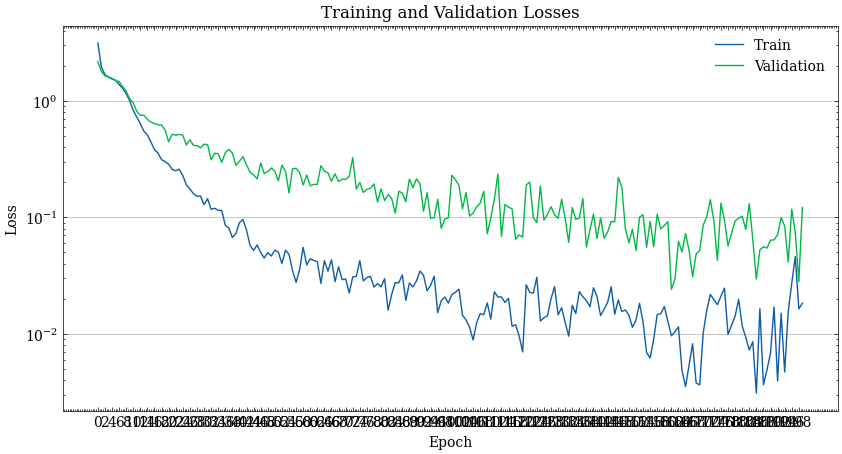

In [ ]:
### PLOT TRANSFORMER LOSSES

visualization.plot_losses(
    train_losses=train_losses_transformer,
    valid_losses=valid_losses_transformer,
    ylog=True,
)


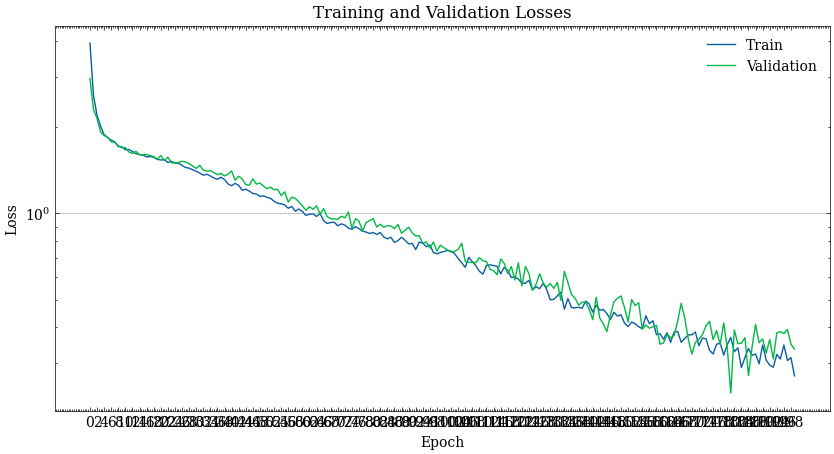

In [ ]:
### PLOT BAYESFORMER LOSSES

visualization.plot_losses(
    train_losses=train_losses_bayesformer,
    valid_losses=valid_losses_bayesformer,
    ylog=True,
)


## **Evaluation**

In [179]:
### EVALUATE TRANSFORMER
accuracy_test_transformer = evaluate(model=transformer, dataset=test_dataset)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")


### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = generate(transformer, prompt_tensor, len(answers)).view((1, -1))

    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


Transformer accuracy on test set: 0.94
659+132=791	 actual result: 791
478+116=594	 actual result: 594
977+251=1228	 actual result: 1228
502+729=1231	 actual result: 1231
189+653=842	 actual result: 842


In [180]:
### EVALUATE BAYESFORMER

accuracy_test_transformer = evaluate(model=bayesformer, dataset=test_dataset)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = generate(transformer, prompt_tensor, len(answers)).view((1, -1))

    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

Transformer accuracy on test set: 0.96
659+132=791	 actual result: 791
478+116=594	 actual result: 594
977+251=1228	 actual result: 1228
502+729=1231	 actual result: 1231
189+653=842	 actual result: 842
